# EXP05: DifEffects

What this notebook does: runs using the different effects model.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
sns.set_style("ticks")

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

%matplotlib inline

In [3]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("../final_data/data_final.csv")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Healthcare Infection Control
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


[('北', 'black'), ('\uf492', 'mediumblue'), ('\uf0c0', 'lightgrey'), ('\uf0c0', 'grey'), ('\uf0c0', 'black'), ('\uf07a', 'tab:orange'), ('\uf07a', 'tab:red'), ('\uf19d', 'black'), ('便', 'black')]


/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 40 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 41 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3

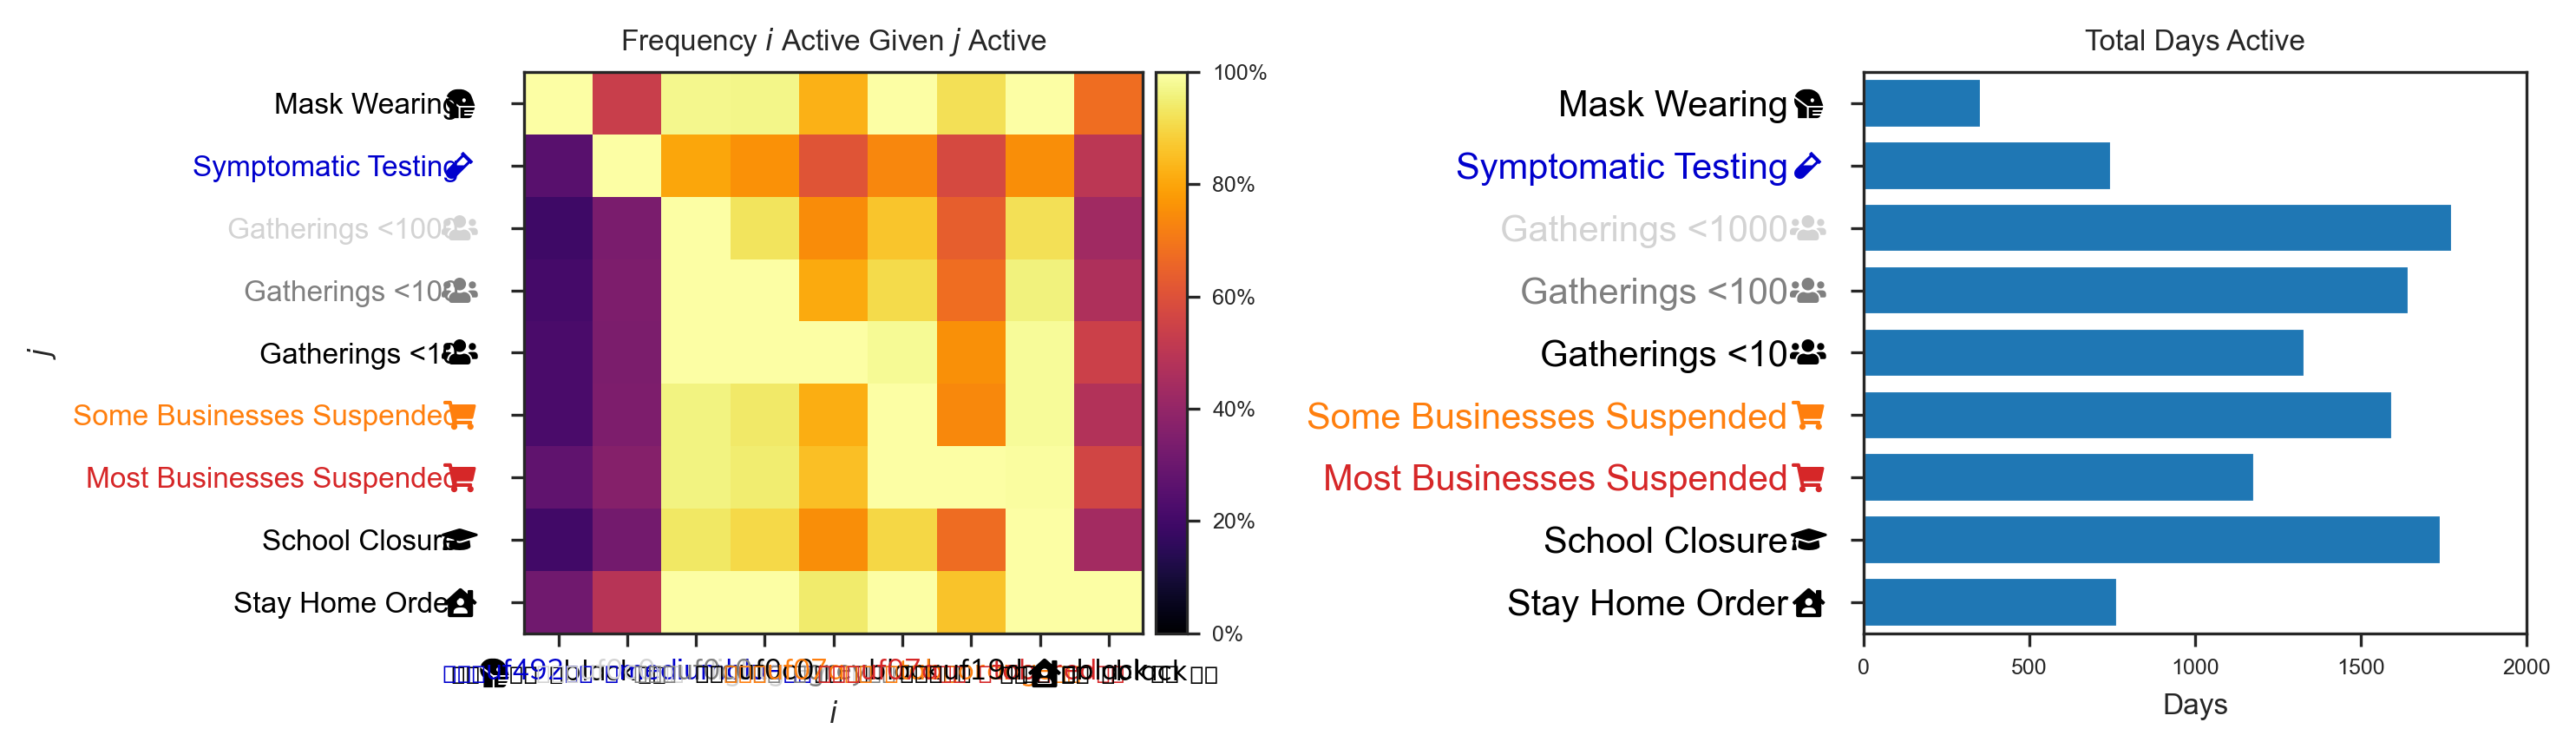

In [5]:
cm_plot_style = [
#             ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf492", "mediumblue"), # vial
            ("\uf0c0", "lightgrey"), # ppl
            ("\uf0c0", "grey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2 
            ("\uf19d", "black"), # school
            ("\uf965", "black") # home
        ]
data.summary_plot(cm_plot_style)

Compared to the usual plot, there are fewer days of schools. 

In [6]:
with cm_effect.models.CMCombined_Final_DifEffects(data, cm_plot_style) as model:
    model.DailyGrowthNoise = 0.2
    model.RegionVariationNoise = 0.1
    model.build_model()

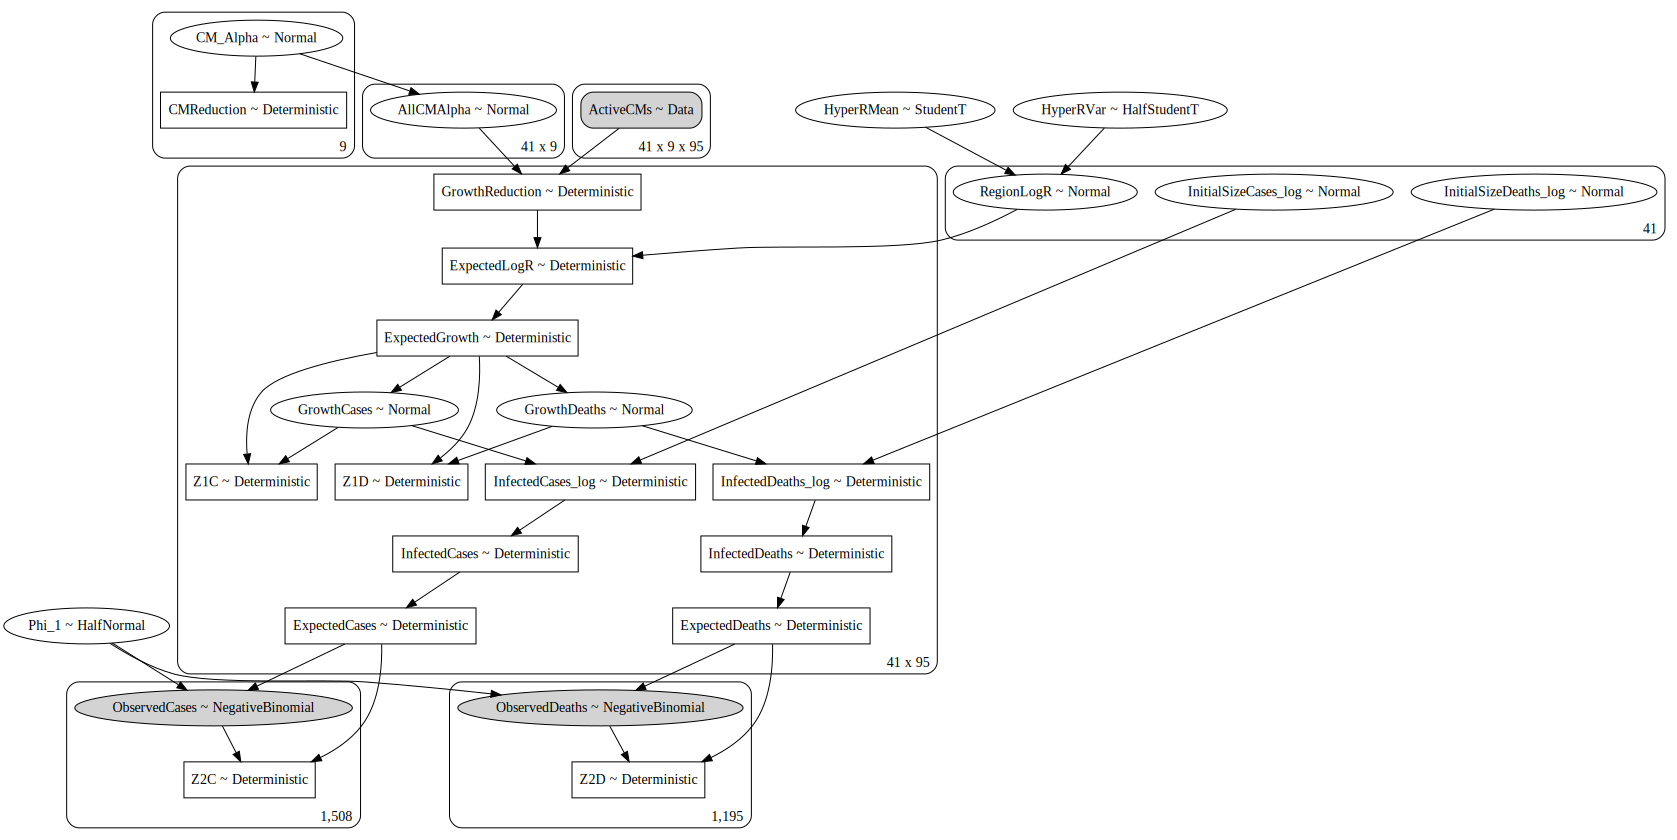

In [7]:
pm.model_to_graphviz(model).render("model-diff-effects")
pm.model_to_graphviz(model)

In [8]:
with model.model:
    model.trace = pm.sample(2000, chains=4, cores=4, target_accept=0.925)
    
pickle.dump(model.trace, open("exp05_diff_effects.pkl", "wb"))

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [InitialSizeDeaths_log, Phi_1, InitialSizeCases_log, GrowthDeaths, GrowthCases, RegionLogR, HyperRVar, HyperRMean, AllCMAlpha, CM_Alpha]
INFO:pymc3:NUTS: [InitialSizeDeaths_log, Phi_1, InitialSizeCases_log, GrowthDeaths, GrowthCases, RegionLogR, HyperRVar, HyperRMean, AllCMAlpha, CM_Alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [2:37:00<00:00,  1.06draws/s] 
The number of effective samples is smaller than 10% for some parameters.


INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/neurips/out at 03-06;13-28


200.0


INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/neurips/out at 03-06;13-28


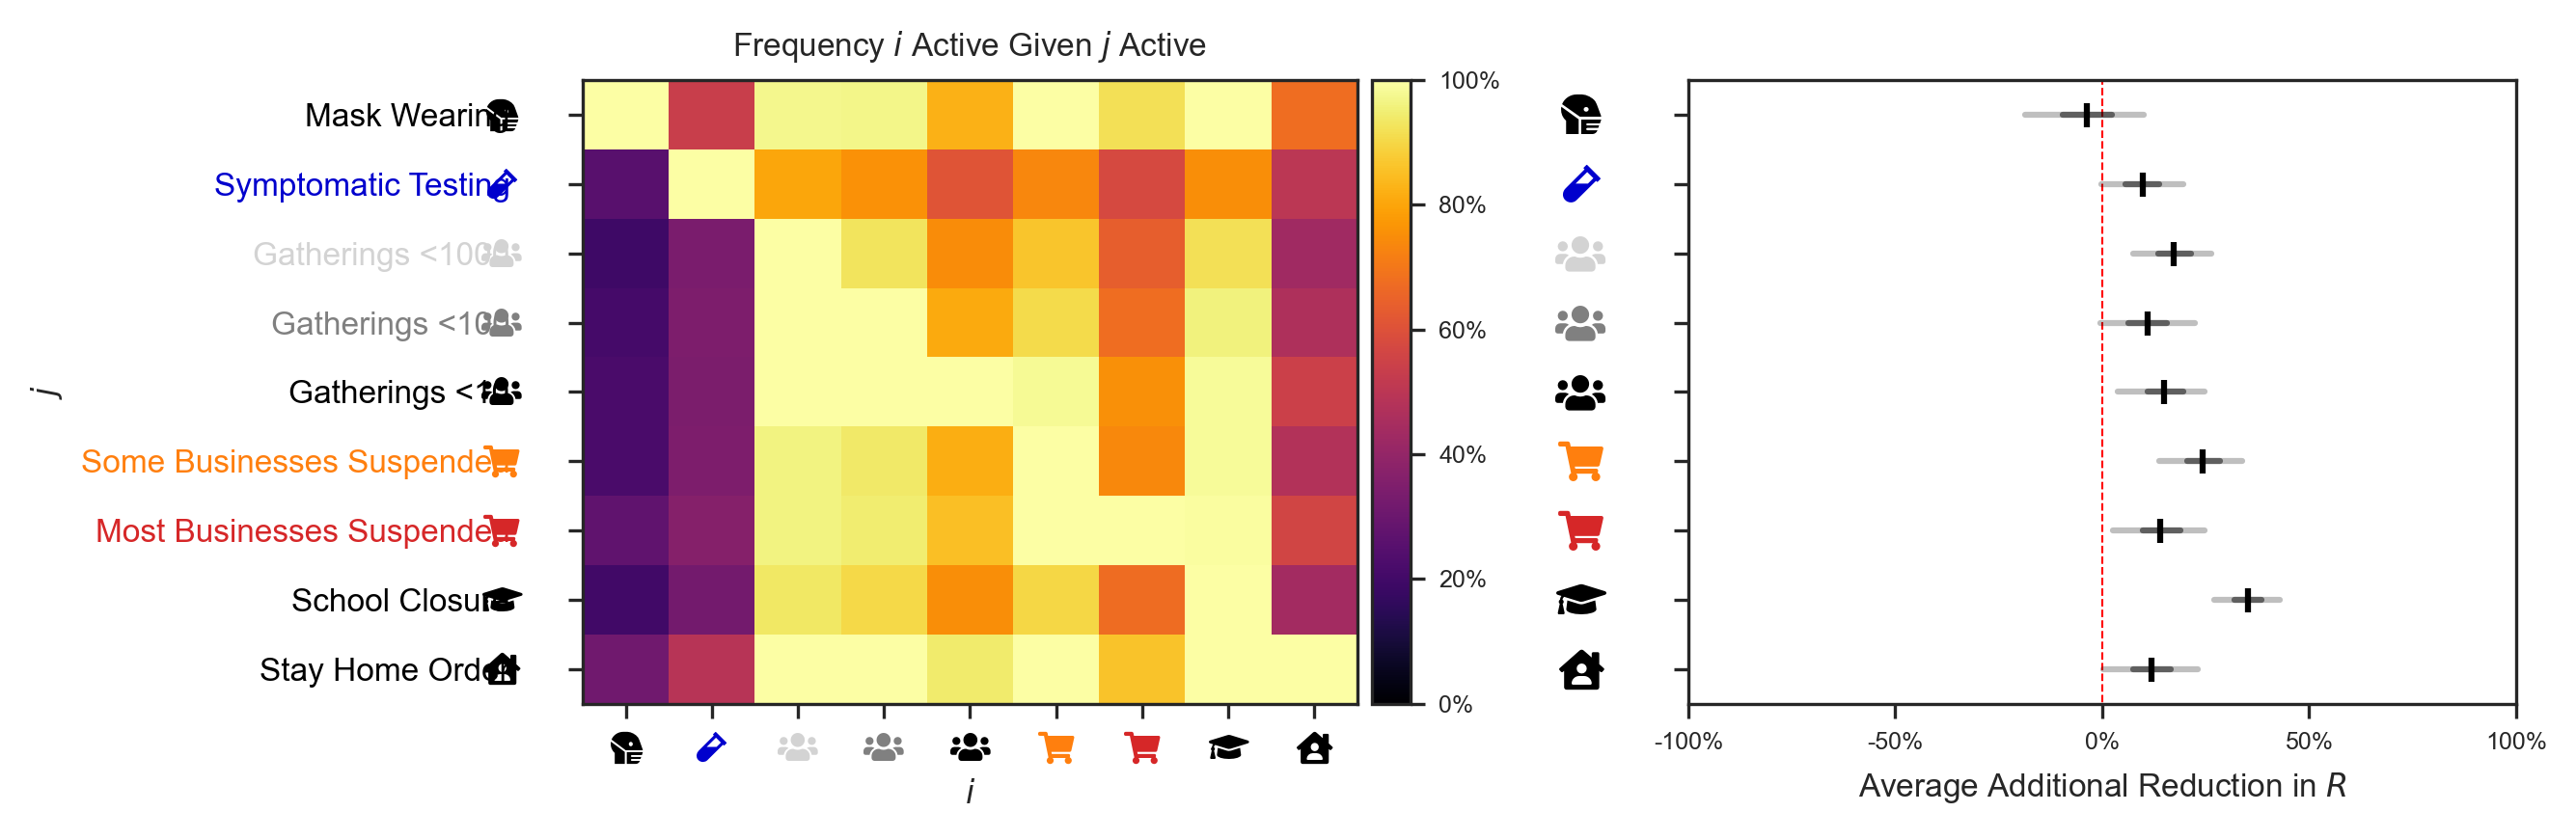

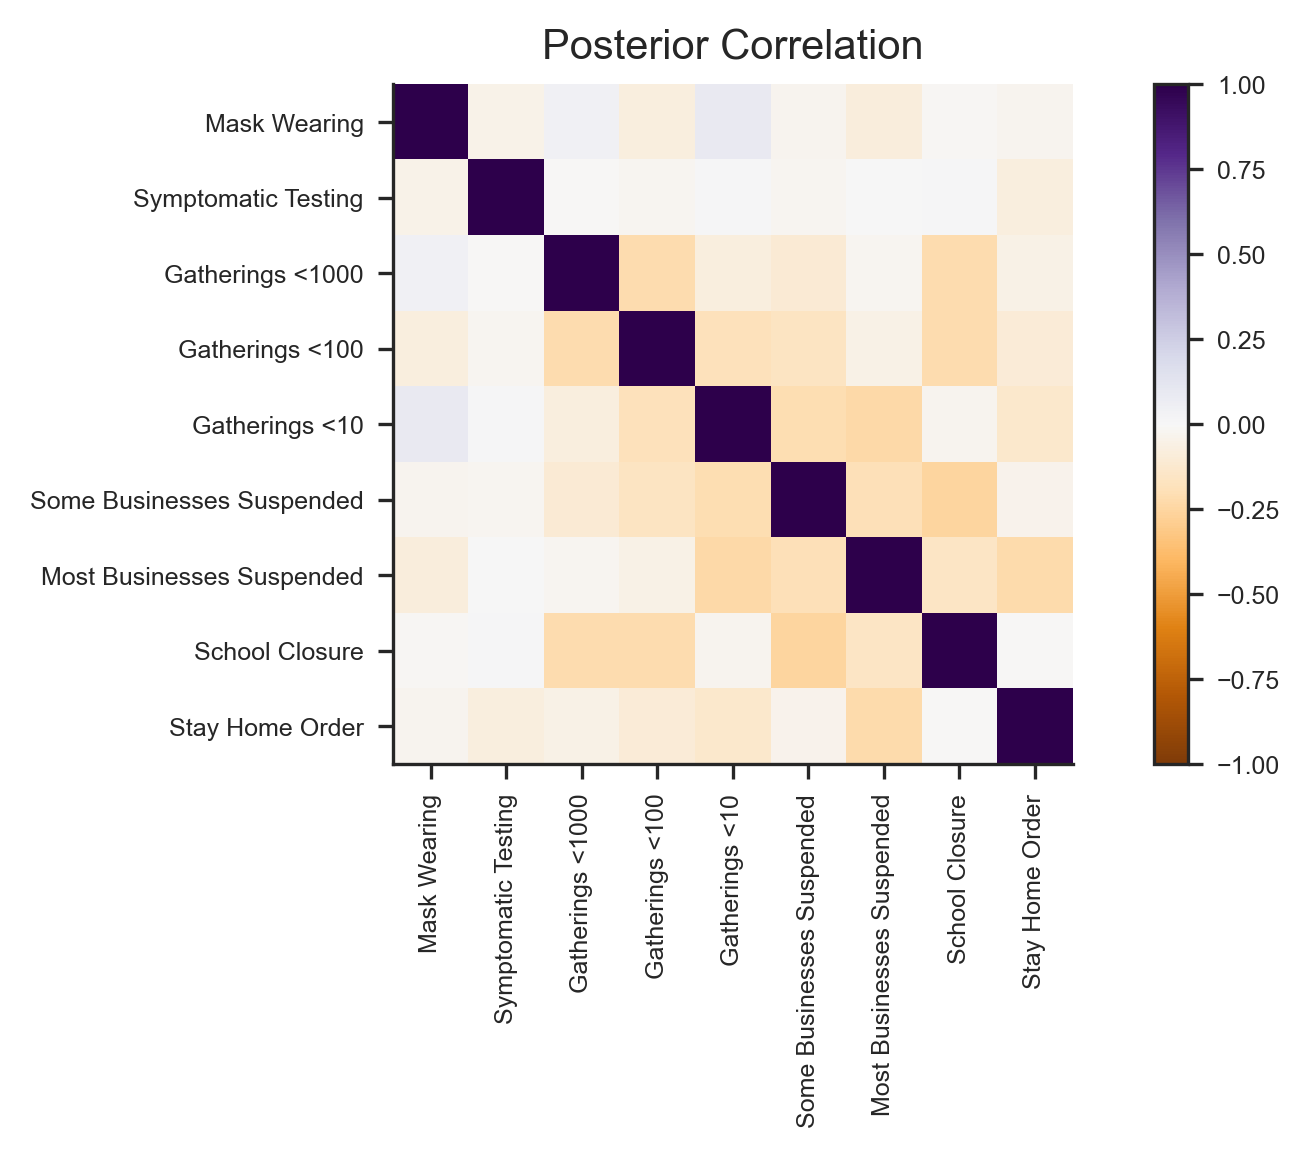

In [10]:
model.plot_effect()

In [10]:
def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq

In [22]:
nS, nRs, nCMs = model.trace["AllCMAlpha"].shape

In [33]:
len(x)

328000

In [36]:
len(g)

328000

In [48]:
import copy

rs = copy.deepcopy(data.Rs)

In [59]:
rs.sort(key = lambda x: np.median(np.exp(-model.trace["AllCMAlpha"])[:, data.Rs.index(x), 0], axis=0))
r_index = [data.Rs.index(r) for r in rs]

In [108]:
np.median(100*(1-model.trace["CMReduction"][:, :]), axis=0)

array([-3.43484439,  9.7412091 , 17.65713447, 11.13648817, 15.44745051,
       24.45048456, 14.18157751, 35.28518237, 12.07809805])

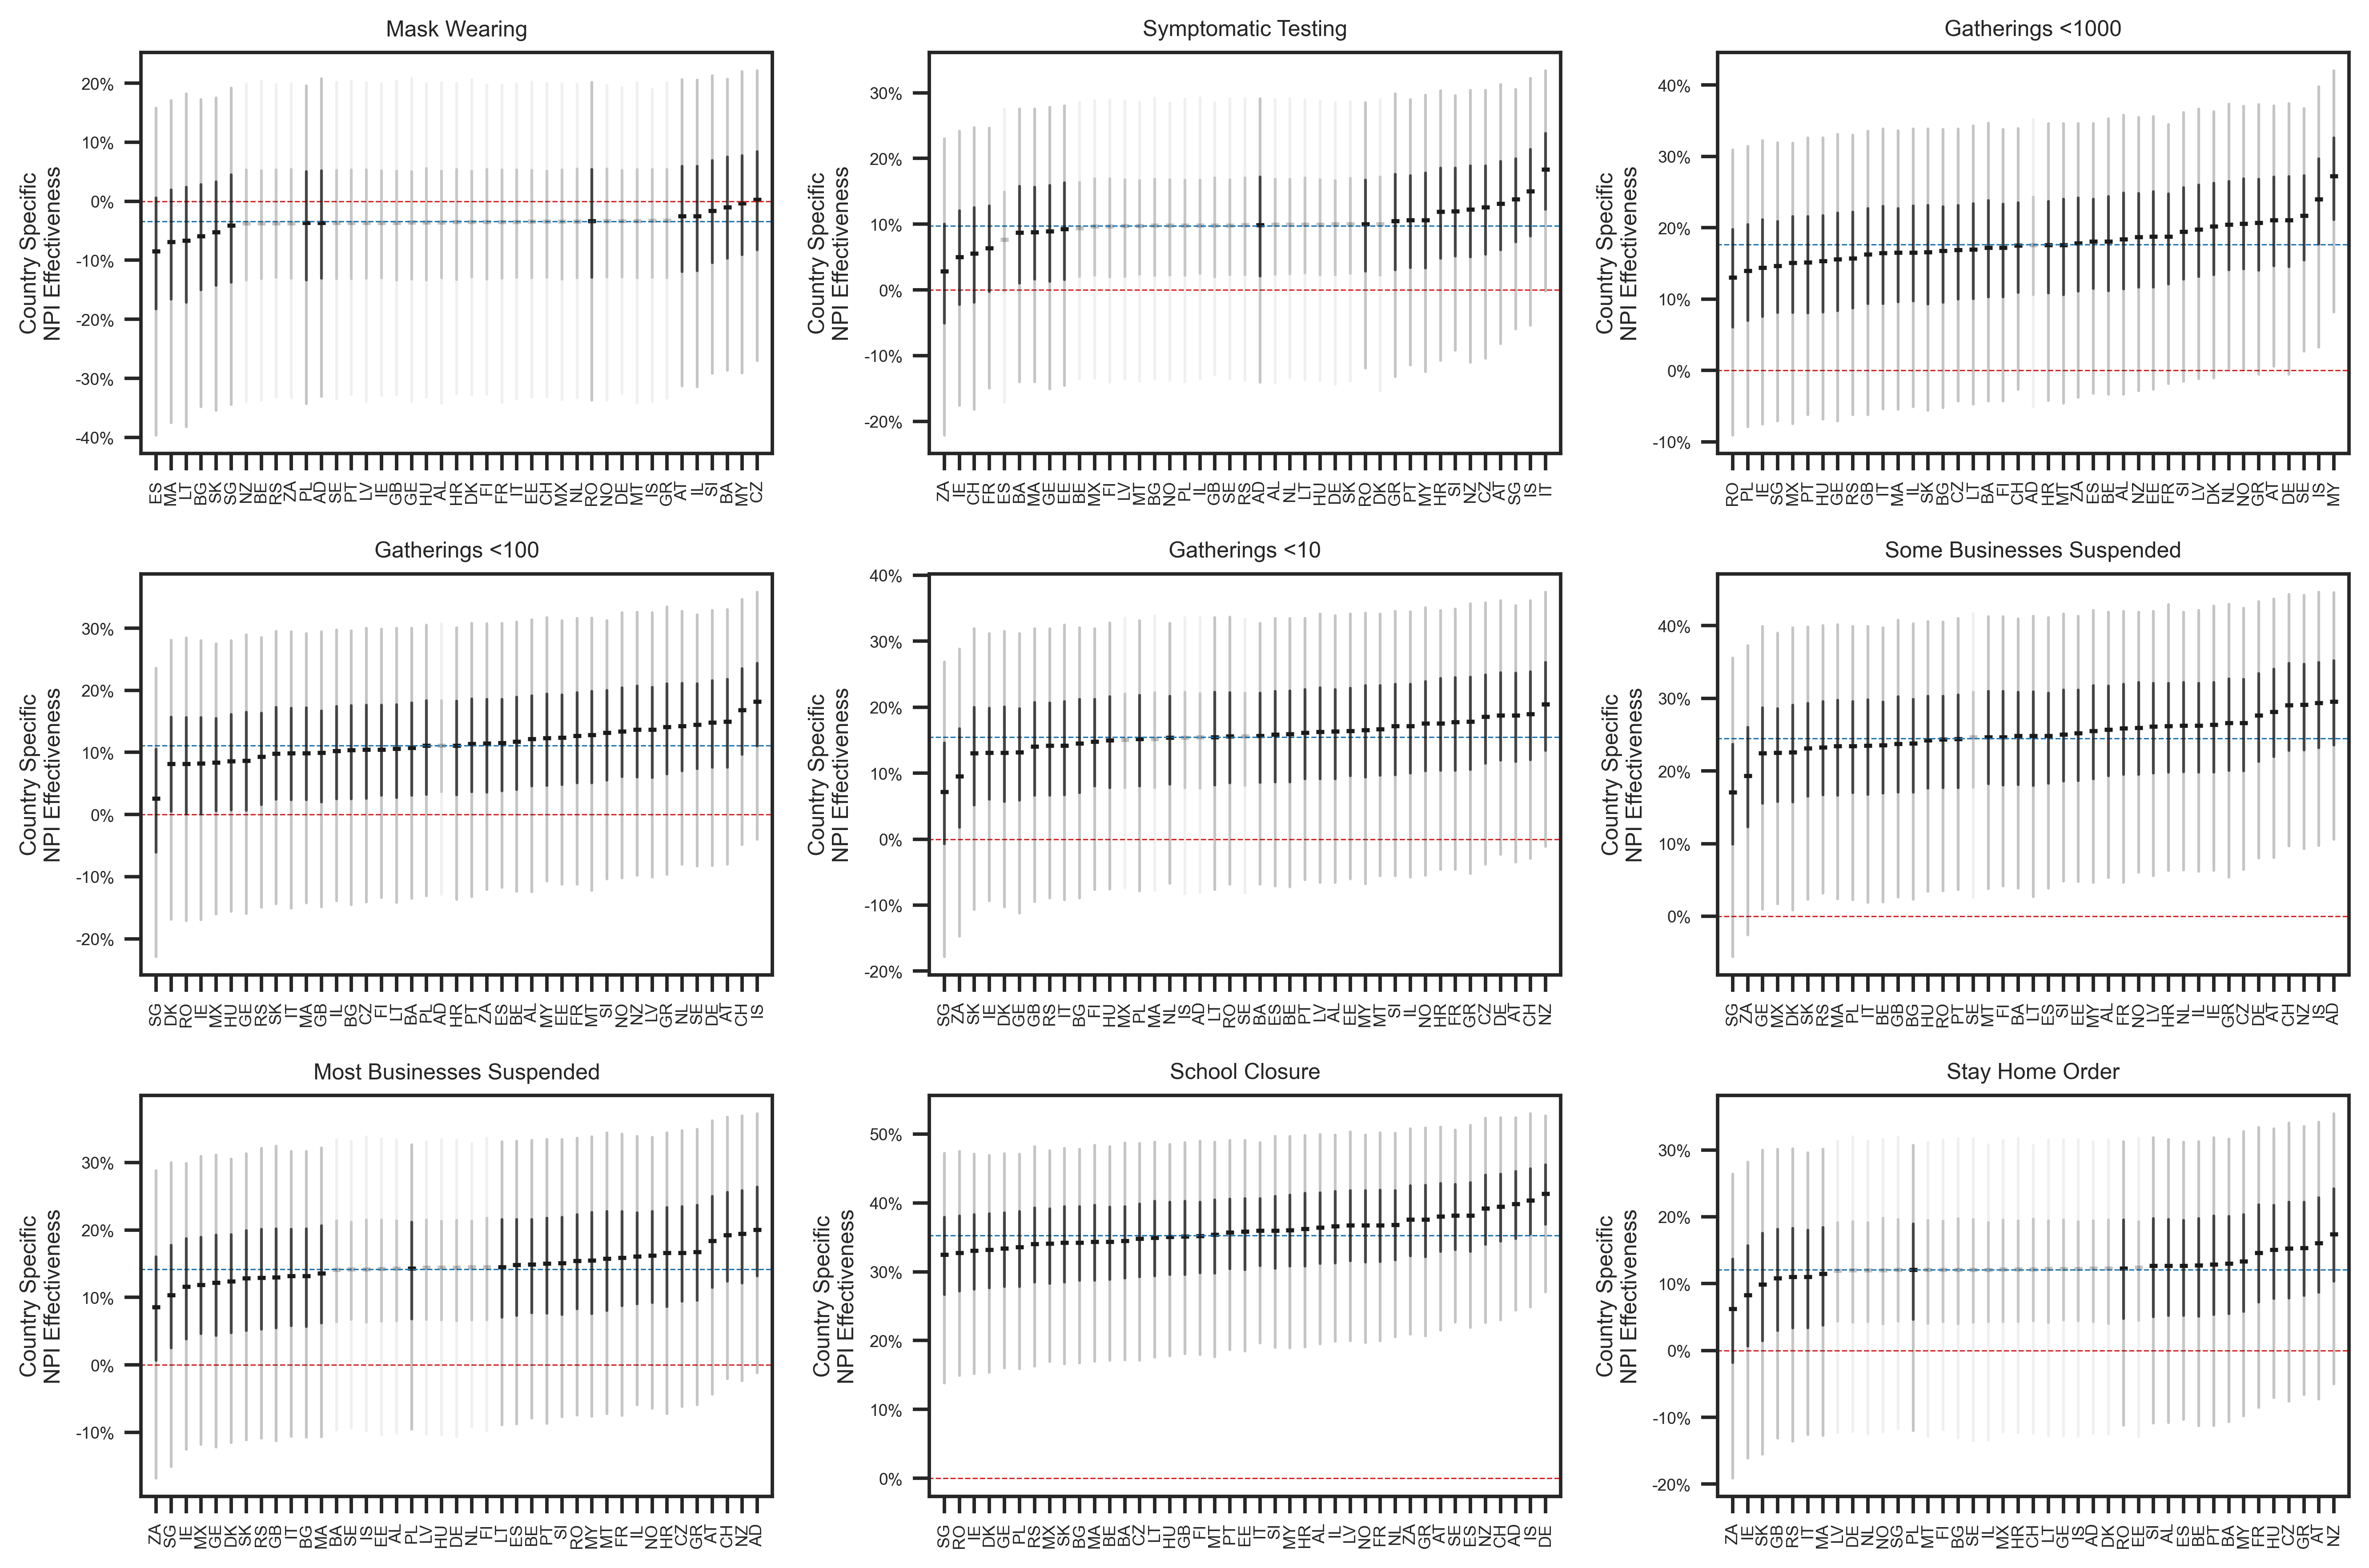

In [164]:
sns.set_style("ticks")
import matplotlib.ticker as mtick

plt.figure(figsize=(12,8), dpi=450)

for cm in range(len(data.CMs)):
    plt.subplot(3, 3, cm+1)
    res = 100*(1-np.exp(-model.trace["AllCMAlpha"]))
    rs.sort(key = lambda x: np.median(res[:, data.Rs.index(x), cm], axis=0))
    r_index = [data.Rs.index(r) for r in rs]

    plt.title(f"{data.CMs[cm]}", fontsize=8)
    plt.xlim([-1, len(r_index)])
    plt.plot([-5, len(r_index)], [0,0], "--", color="tab:red", linewidth=0.5)

    median = 100*(1-np.median(model.trace["CMReduction"][:, cm]))
    plt.plot([-5, len(r_index)], [median, median], "--", color="tab:blue", linewidth=0.5)

    plt.xticks(np.arange(len(r_index)), rs, rotation=90)
    for i, (r, r_i) in enumerate(zip(rs, r_index)):
        mn, med, li, ui, lq, uq = produce_ranges(res[:, r_i, cm])
        
        days_active = np.sum(data.ActiveCMs[r_i, cm, :])
            
        if days_active < 7:
            alpha_mult = 0.25
        else:
            alpha_mult = 1
    
        mn, med, li, ui, lq, uq = produce_ranges(res[:, r_i, cm])
        plt.scatter(i, med, marker="_", s=8, color="k", alpha=1*alpha_mult)
        plt.plot([i, i], [li, ui], color="k", alpha=0.25*alpha_mult, linewidth=1)
        plt.plot([i, i], [lq, uq], color="k", alpha=0.75*alpha_mult, linewidth=1)

    plt.ylabel("Country Specific\nNPI Effectiveness", fontsize=8)
    ax = plt.gca()
    ax.tick_params(axis="both", which="major", labelsize=6)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
plt.tight_layout()

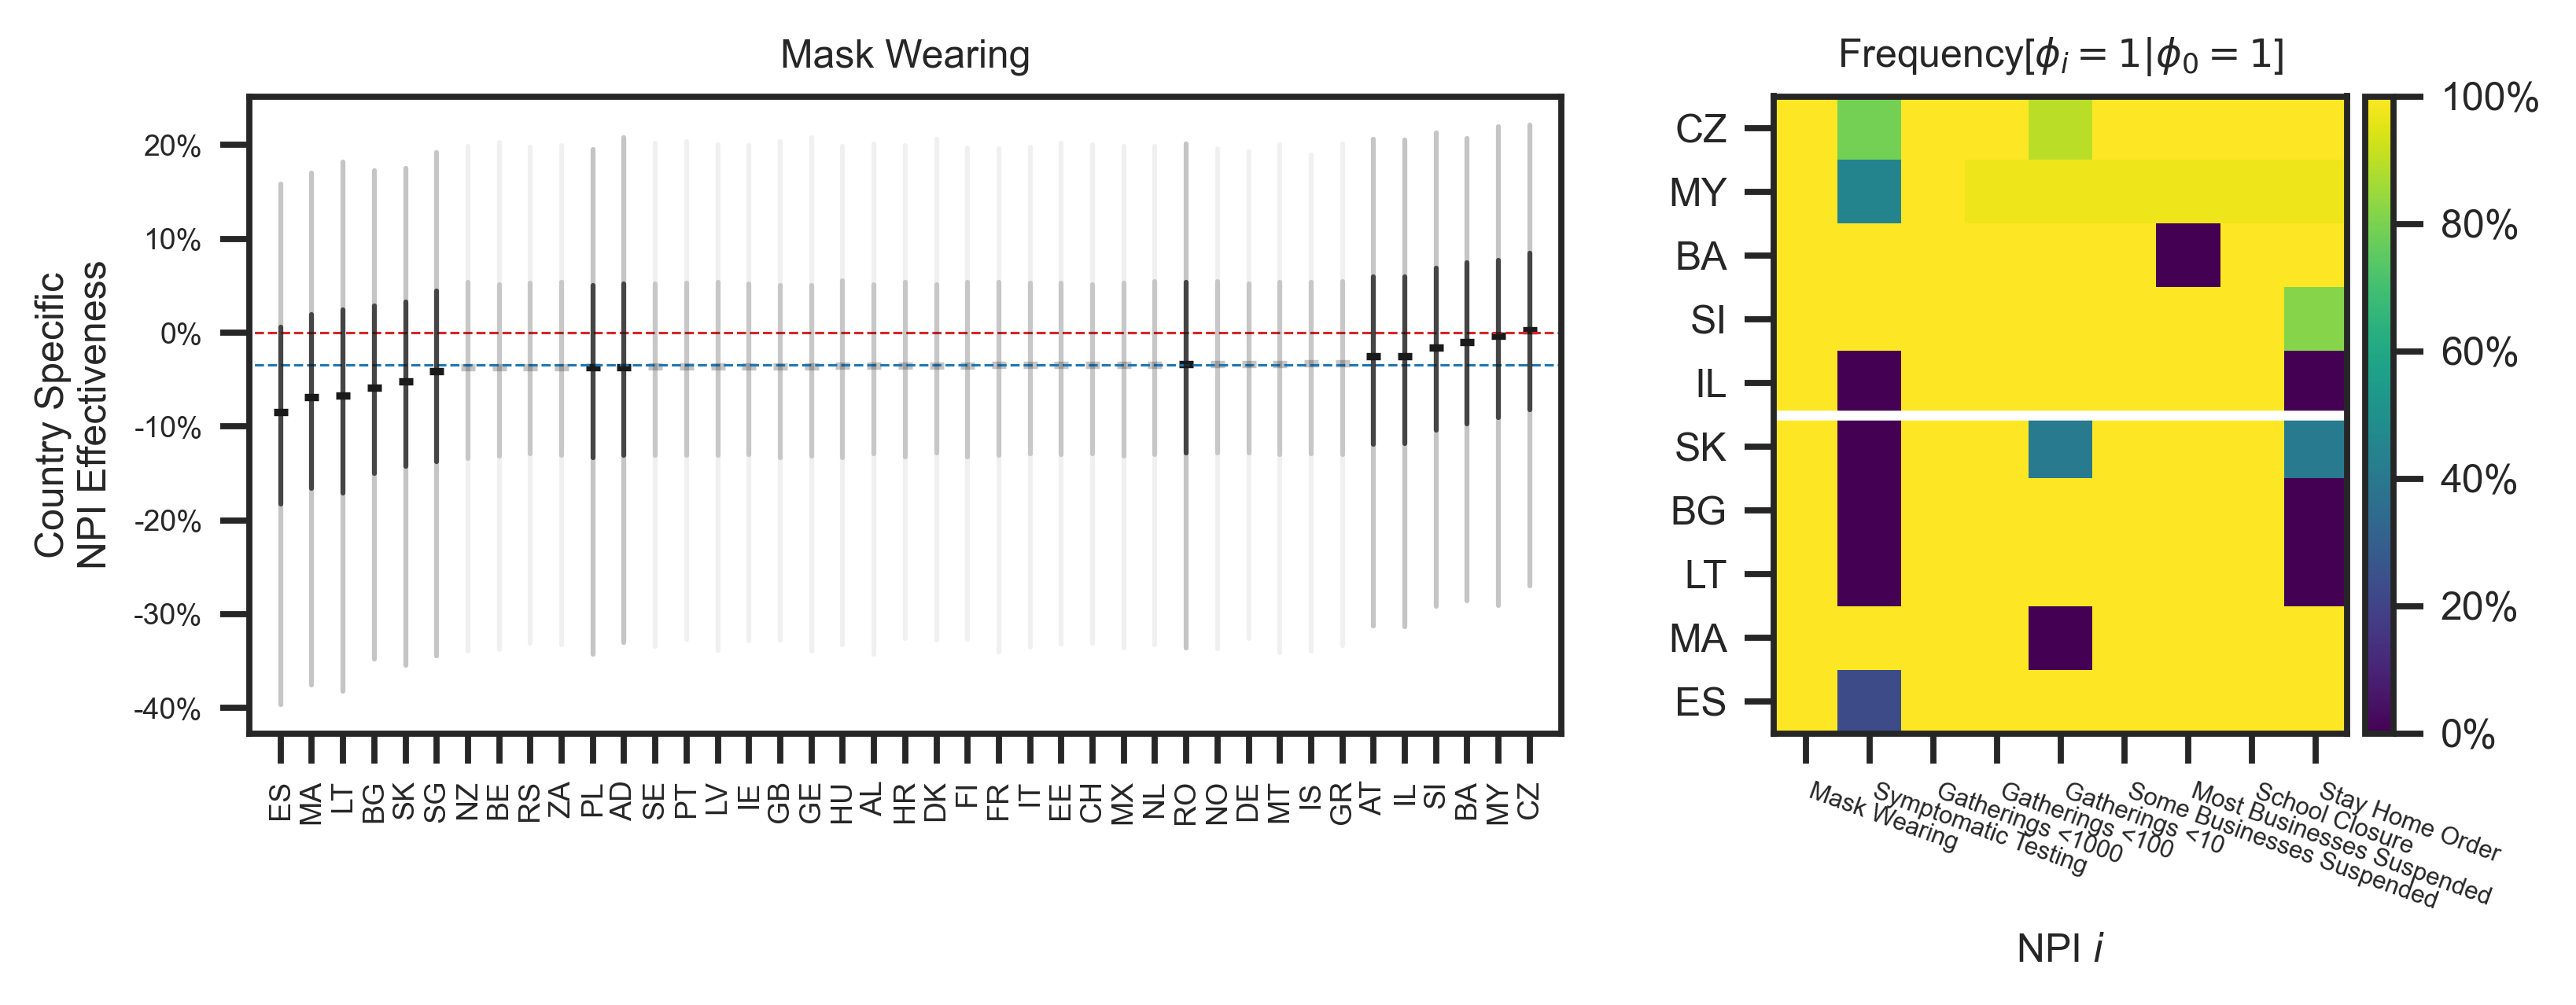

In [183]:
plt.figure(figsize=(8, 3), dpi=450)
cm = 0
plt.subplot(1, 2, 1)
res = 100*(1-np.exp(-model.trace["AllCMAlpha"]))
rs.sort(key = lambda x: np.median(res[:, data.Rs.index(x), cm], axis=0))
r_index = [data.Rs.index(r) for r in rs]

plt.title(f"{data.CMs[cm]}", fontsize=8)
plt.xlim([-1, len(r_index)])
plt.plot([-5, len(r_index)], [0,0], "--", color="tab:red", linewidth=0.5)

median = 100*(1-np.median(model.trace["CMReduction"][:, cm]))
plt.plot([-5, len(r_index)], [median, median], "--", color="tab:blue", linewidth=0.5)

plt.xticks(np.arange(len(r_index)), rs, rotation=90)
for i, (r, r_i) in enumerate(zip(rs, r_index)):

    days_active = np.sum(data.ActiveCMs[r_i, cm, :])

    if days_active < 7:
        alpha_mult = 0.25
    else:
        alpha_mult = 1

    mn, med, li, ui, lq, uq = produce_ranges(res[:, r_i, cm])
    plt.scatter(i, med, marker="_", s=8, color="k", alpha=1*alpha_mult)
    plt.plot([i, i], [li, ui], color="k", alpha=0.25*alpha_mult, linewidth=1)
    plt.plot([i, i], [lq, uq], color="k", alpha=0.75*alpha_mult, linewidth=1)

plt.ylabel("Country Specific\nNPI Effectiveness", fontsize=8)
ax = plt.gca()
ax.tick_params(axis="both", which="major", labelsize=6)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.subplot(1, 2, 2)

tp = [*rs[:5], *rs[-5:]]
tp.reverse()
mat = np.zeros((len(tp), nCMs))
for i, r in enumerate(tp):
    counts = np.sum(data.ActiveCMs[data.Rs.index(r), :, : ] * data.ActiveCMs[data.Rs.index(r), cm, :] == 1, axis=1)
    counts = counts/counts[cm]
    mat[i, :] = counts
plt.yticks(np.arange(len(tp)), tp, fontsize=8)
im = plt.imshow(100*mat, cmap="viridis", vmax=100, vmin=0)
plt.plot([-1, 10], [4.5, 4.5], color="white", linewidth="2")
plt.xlim([-0.5, 8.5])
plt.xlabel("NPI $i$", fontsize=8)
plt.xticks(np.arange(len(data.CMs)), data.CMs, ha="left", rotation=-20, fontsize=5)
plt.title(f"Frequency[$\phi_i = 1| \phi_{cm} = 1$]", fontsize=8)

plt.tight_layout()
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, format=PercentFormatter())
ax = plt.gca()
ax.tick_params(axis="both", which="major", labelsize=8)

plt.tight_layout()
plt.savefig(f"FigureSAnew.pdf", bbox_inches='tight')

In [7]:
model.trace = pickle.load(open("exp05_diff_effects.pkl", "rb"))

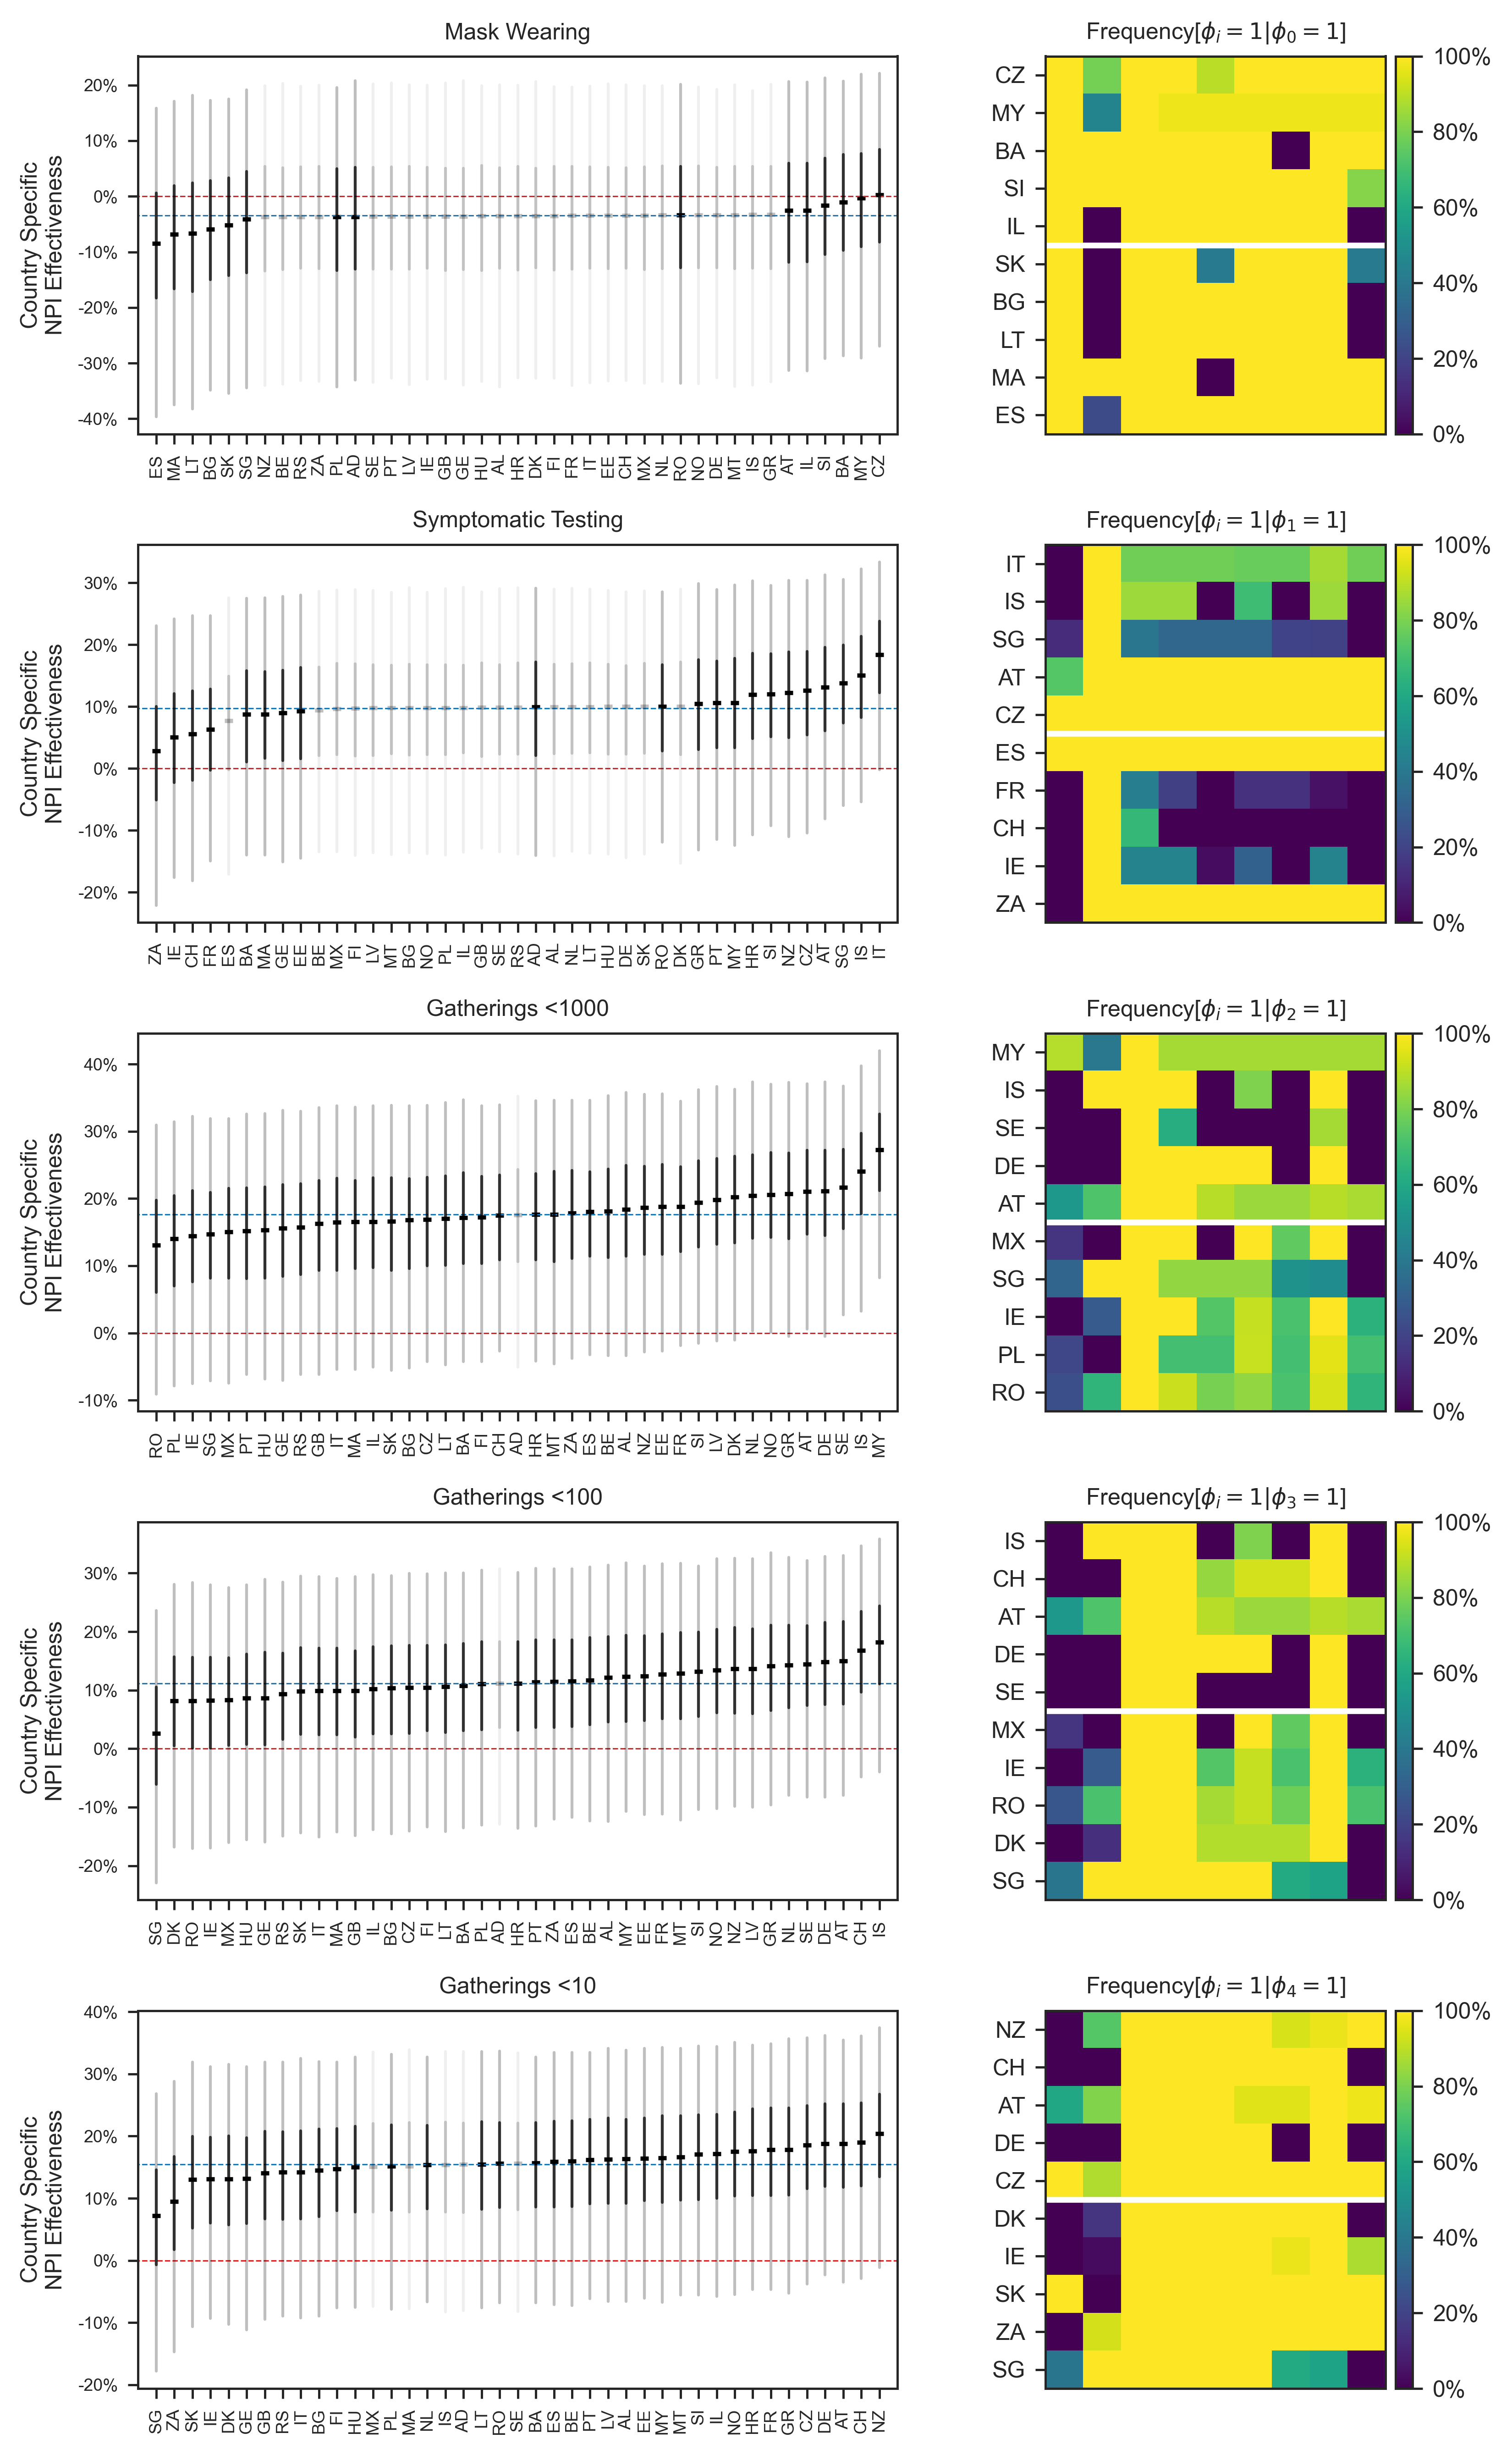

In [16]:

plt.figure(figsize=(8,12), dpi=450)

for cm in [0, 1, 2, 3, 4]:
    plt.subplot(5, 2, cm*2 + 1)
    res = 100*(1-np.exp(-model.trace["AllCMAlpha"]))
    rs.sort(key = lambda x: np.median(res[:, data.Rs.index(x), cm], axis=0))
    r_index = [data.Rs.index(r) for r in rs]

    plt.title(f"{data.CMs[cm]}", fontsize=8)
    plt.xlim([-1, len(r_index)])
    plt.plot([-5, len(r_index)], [0,0], "--", color="tab:red", linewidth=0.5)

    median = 100*(1-np.median(model.trace["CMReduction"][:, cm]))
    plt.plot([-5, len(r_index)], [median, median], "--", color="tab:blue", linewidth=0.5)

    plt.xticks(np.arange(len(r_index)), rs, rotation=90)
    for i, (r, r_i) in enumerate(zip(rs, r_index)):

        days_active = np.sum(data.ActiveCMs[r_i, cm, :])

        if days_active < 7:
            alpha_mult = 0.25
        else:
            alpha_mult = 1

        mn, med, li, ui, lq, uq = produce_ranges(res[:, r_i, cm])
        plt.scatter(i, med, marker="_", s=8, color="k", alpha=1*alpha_mult)
        plt.plot([i, i], [li, ui], color="k", alpha=0.25*alpha_mult, linewidth=1)
        plt.plot([i, i], [lq, uq], color="k", alpha=0.75*alpha_mult, linewidth=1)

    plt.ylabel("Country Specific\nNPI Effectiveness", fontsize=8)
    ax = plt.gca()
    ax.tick_params(axis="both", which="major", labelsize=6)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    plt.subplot(5, 2, cm*2 + 2)

    tp = [*rs[:5], *rs[-5:]]
    tp.reverse()
    mat = np.zeros((len(tp), nCMs))
    for i, r in enumerate(tp):
        counts = np.sum(data.ActiveCMs[data.Rs.index(r), :, : ] * data.ActiveCMs[data.Rs.index(r), cm, :] == 1, axis=1)
        counts = counts/counts[cm]
        mat[i, :] = counts
    plt.yticks(np.arange(len(tp)), tp, fontsize=8)
    im = plt.imshow(100*mat, cmap="viridis", vmax=100, vmin=0)
    plt.plot([-1, 10], [4.5, 4.5], color="white", linewidth="2")
    plt.xlim([-0.5, 8.5])
    
    if i == 4:
        plt.xlabel("NPI $i$", fontsize=8)
        plt.xticks(np.arange(len(data.CMs)), data.CMs, ha="left", rotation=-20, fontsize=6)
    else:
        plt.xticks([])
    plt.title(f"Frequency[$\phi_i = 1| \phi_{cm} = 1$]", fontsize=8)


    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, format=PercentFormatter())
    ax = plt.gca()
    ax.tick_params(axis="both", which="major", labelsize=8)

plt.tight_layout()
plt.savefig(f"all_one.pdf", bbox_inches='tight')

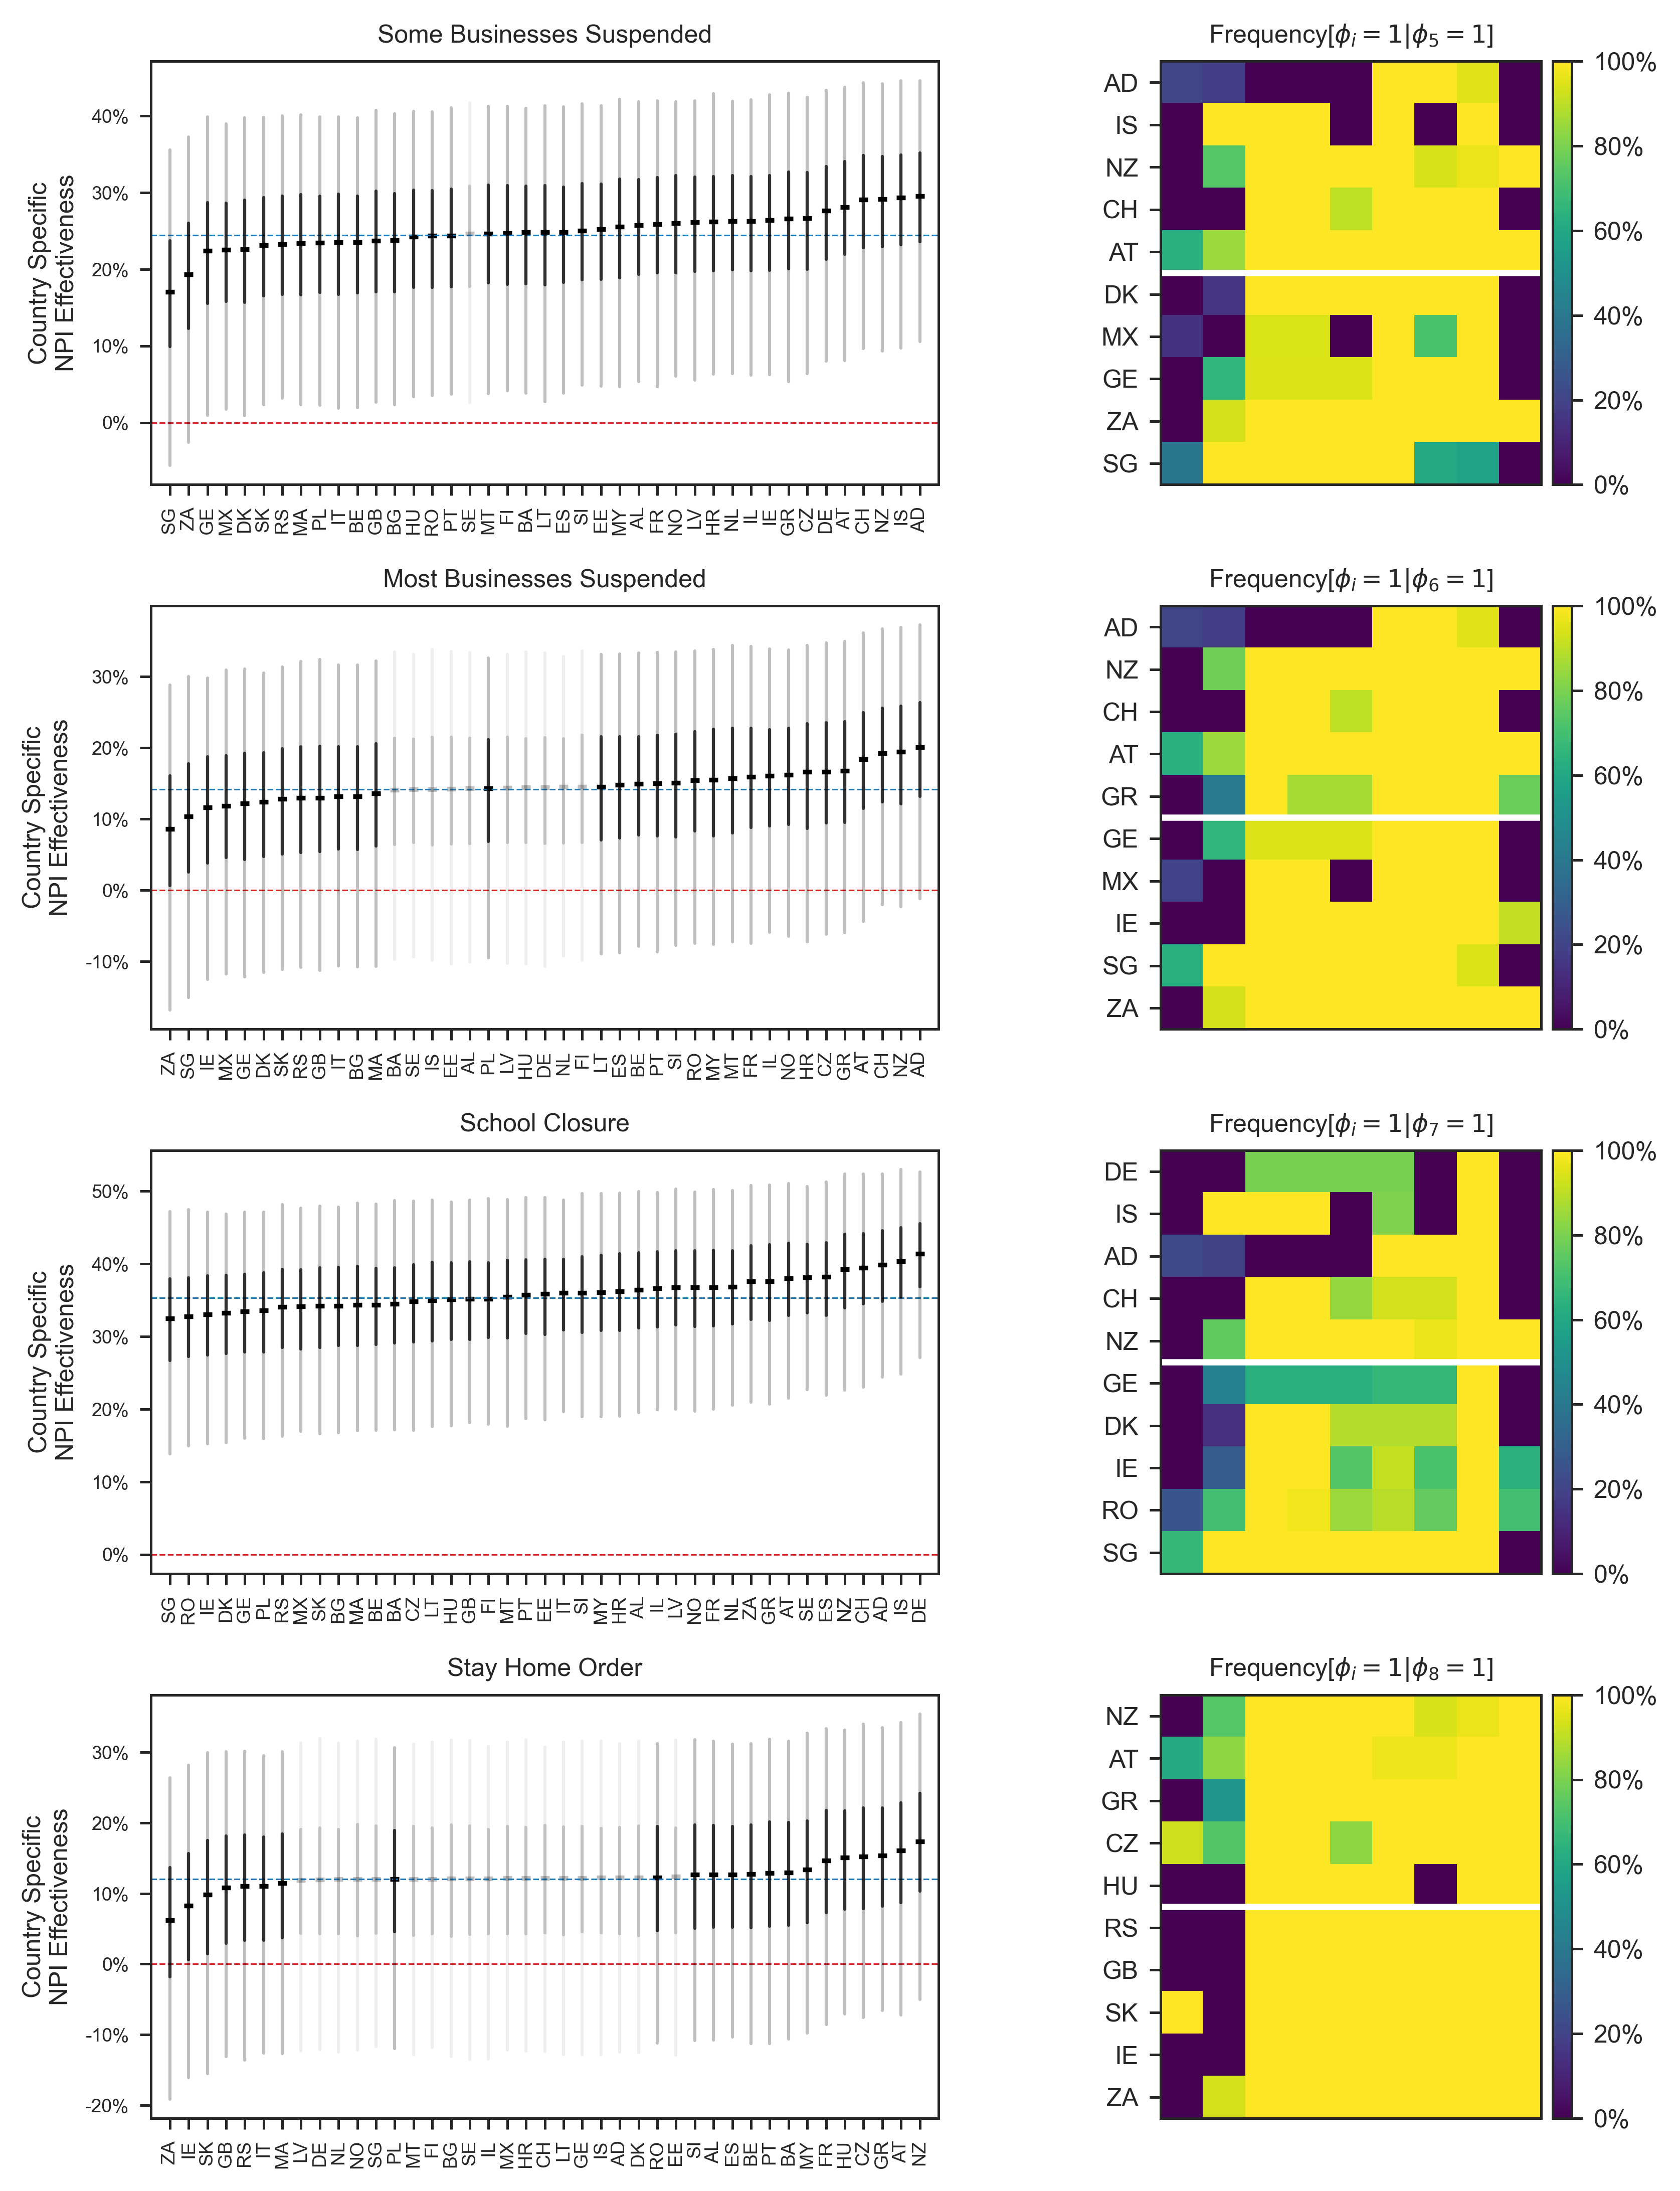

In [17]:
rs = copy.deepcopy(data.Rs)

sns.set_style("ticks")
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import PercentFormatter
nCMs = 9

plt.figure(figsize=(8,12), dpi=450)

for cm in [5, 6, 7, 8]:
    plt.subplot(5, 2, (cm-5)*2 + 1)
    res = 100*(1-np.exp(-model.trace["AllCMAlpha"]))
    rs.sort(key = lambda x: np.median(res[:, data.Rs.index(x), cm], axis=0))
    r_index = [data.Rs.index(r) for r in rs]

    plt.title(f"{data.CMs[cm]}", fontsize=8)
    plt.xlim([-1, len(r_index)])
    plt.plot([-5, len(r_index)], [0,0], "--", color="tab:red", linewidth=0.5)

    median = 100*(1-np.median(model.trace["CMReduction"][:, cm]))
    plt.plot([-5, len(r_index)], [median, median], "--", color="tab:blue", linewidth=0.5)

    plt.xticks(np.arange(len(r_index)), rs, rotation=90)
    for i, (r, r_i) in enumerate(zip(rs, r_index)):

        days_active = np.sum(data.ActiveCMs[r_i, cm, :])

        if days_active < 7:
            alpha_mult = 0.25
        else:
            alpha_mult = 1

        mn, med, li, ui, lq, uq = produce_ranges(res[:, r_i, cm])
        plt.scatter(i, med, marker="_", s=8, color="k", alpha=1*alpha_mult)
        plt.plot([i, i], [li, ui], color="k", alpha=0.25*alpha_mult, linewidth=1)
        plt.plot([i, i], [lq, uq], color="k", alpha=0.75*alpha_mult, linewidth=1)

    plt.ylabel("Country Specific\nNPI Effectiveness", fontsize=8)
    ax = plt.gca()
    ax.tick_params(axis="both", which="major", labelsize=6)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    plt.subplot(5, 2, (cm-5)*2 + 2)

    tp = [*rs[:5], *rs[-5:]]
    tp.reverse()
    mat = np.zeros((len(tp), nCMs))
    for i, r in enumerate(tp):
        counts = np.sum(data.ActiveCMs[data.Rs.index(r), :, : ] * data.ActiveCMs[data.Rs.index(r), cm, :] == 1, axis=1)
        counts = counts/counts[cm]
        mat[i, :] = counts
    plt.yticks(np.arange(len(tp)), tp, fontsize=8)
    im = plt.imshow(100*mat, cmap="viridis", vmax=100, vmin=0)
    plt.plot([-1, 10], [4.5, 4.5], color="white", linewidth="2")
    plt.xlim([-0.5, 8.5])
    
    if i == 4:
        plt.xlabel("NPI $i$", fontsize=8)
        plt.xticks(np.arange(len(data.CMs)), data.CMs, ha="left", rotation=-20, fontsize=6)
    else:
        plt.xticks([])
    plt.title(f"Frequency[$\phi_i = 1| \phi_{cm} = 1$]", fontsize=8)


    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, format=PercentFormatter())
    ax = plt.gca()
    ax.tick_params(axis="both", which="major", labelsize=8)

plt.tight_layout()
plt.savefig(f"all_two.pdf", bbox_inches='tight')